# S&P 500 Stock Analysis Project
**Data Wrangling Project** <br>
Nitan Tantawichian <br>
04/01/2025

### Final Output Goal
1. Stock performance (price change %, volume)
2. Buy/Sell/Hold signal for each stock
3. Sector analysis (average performance)
4. Which stocks had unusual high trading volume today?

### Web Scraping Sources
1. https://www.tradingview.com/symbols/SPX/components/
   - Live performance data
   - **Info to extract:** Symbol, Company Name, Price, % Change, Volume
2. https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
   - Company information
   - **Info to extract:** Symbol and GICS Sector
3. Yahoo Finance (yfinance)
   - Historical price data
   - **Info to extract:** Date, Open, Close, High, Low, Volume

In [1]:
# Import necessary packages
import pandas as pd
import yfinance as yf
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time
import random

### Scrape all 503 S&P 500 stocks from TradingView

In [2]:
# Set up a browser
browser = webdriver.ChromeOptions()

# Launch browser
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()), options = browser)

# Navigate to TradingView SPX Components
url = "https://www.tradingview.com/symbols/SPX/components/"
driver.get(url)
time.sleep(5) 

# Scrape the data
while True:
    try:
        # Scroll to bottom to trigger button appearance
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        # Click the Load More button if available
        load_more_button = driver.find_element(By.XPATH, '//button[.//span[text()="Load More"]]')
        driver.execute_script("arguments[0].click();", load_more_button)
        print("Clicked Load More...")
        time.sleep(2)
    except Exception as e:
        print("Finished loading all companies or button not found.")
        break

# Extract table rows
rows = driver.find_elements(By.XPATH, "//table//tbody//tr")

# Loop through and extract data
data = []
for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) >= 5:
        Symbol_block = cols[0].text.strip().split("\n")
        Symbol = Symbol_block[0]
        Name = Symbol_block[1] if len(Symbol_block) > 1 else ""
        Price = cols[2].text
        Change = cols[3].text
        Volume = cols[4].text
        data.append([Symbol, Name, Price, Change, Volume])

# Close browser
driver.quit()

Clicked Load More...
Clicked Load More...
Clicked Load More...
Clicked Load More...
Clicked Load More...
Finished loading all companies or button not found.


In [3]:
# Create a dataframe
tradingview_stock = pd.DataFrame(data, columns = ["Symbol", "Company Name", "Stock Price", "Price % Change", "Volume"])

In [4]:
display(tradingview_stock)

,Symbol,Company Name,Stock Price,Price % Change,Volume
0,AAPL,Apple Inc.,209.28 USD,+0.44%,38.22 M
1,MSFT,Microsoft Corporation,391.85 USD,+1.17%,18.97 M
2,NVDA,NVIDIA Corporation,111.01 USD,+4.30%,251.05 M
3,AMZN,"Amazon.com, Inc.",188.99 USD,+1.31%,36.41 M
4,GOOG,Alphabet Inc.,163.85 USD,+1.47%,35.15 M
...,...,...,...,...,...
498,IVZ,Invesco Ltd,13.93 USD,−1.00%,6.26 M
499,ENPH,"Enphase Energy, Inc.",46.83 USD,+2.36%,4.64 M
500,CZR,"Caesars Entertainment, Inc.",28.44 USD,+4.67%,5.51 M
501,APA,APA Corporation,16.35 USD,+0.55%,4.64 M


In [5]:
# Check the intial data types
print(f"Initial data types:\n {tradingview_stock.dtypes}")

Initial data types:
 Symbol            object
Company Name      object
Stock Price       object
Price % Change    object
Volume            object
dtype: object


### Clean the TradingView Data Frame

In [6]:
# Rename symbol to ticker and keep all columns
tradingview_stock.rename(columns = {"Symbol": "Ticker"}, inplace = True)

# Convert ticker and company name to string
tradingview_stock["Ticker"] = tradingview_stock["Ticker"].astype(str)
tradingview_stock["Company Name"] = tradingview_stock["Company Name"].astype(str)

# Clean and convert stock price
tradingview_stock["Stock Price"] = (
    tradingview_stock["Stock Price"]
    .str.replace(",", "")
    .str.replace(" USD", "")
    .astype(float)
)

# Clean and convert price % change
tradingview_stock["Price % Change (Numeric)"] = (
    tradingview_stock["Price % Change"]
    .str.replace("−", "-")  # Unicode minus fix
    .str.replace("%", "")
    .astype(float)
)

# Clean and convert volume
def convert_volume(val):
    try:
        val = val.replace(",", "").strip()
        if val.endswith("K"):
            return float(val[:-1]) * 1_000
        elif val.endswith("M"):
            return float(val[:-1]) * 1_000_000
        elif val.endswith("B"):
            return float(val[:-1]) * 1_000_000_000
        elif val.endswith("T"):
            return float(val[:-1]) * 1_000_000_000_000
        else:
            return float(val)
    except:
        return None

# Apply conversion to Volume column
tradingview_stock["Volume"] = tradingview_stock["Volume"].apply(convert_volume).astype(float)

In [7]:
# Check the data types after cleaning
print(f"After converting data types:\n {tradingview_stock.dtypes}")
display(tradingview_stock)

After converting data types:
 Ticker                       object
Company Name                 object
Stock Price                 float64
Price % Change               object
Volume                      float64
Price % Change (Numeric)    float64
dtype: object


,Ticker,Company Name,Stock Price,Price % Change,Volume,Price % Change (Numeric)
0,AAPL,Apple Inc.,209.28,+0.44%,38220000.0,0.44
1,MSFT,Microsoft Corporation,391.85,+1.17%,18970000.0,1.17
2,NVDA,NVIDIA Corporation,111.01,+4.30%,251050000.0,4.30
3,AMZN,"Amazon.com, Inc.",188.99,+1.31%,36410000.0,1.31
4,GOOG,Alphabet Inc.,163.85,+1.47%,35150000.0,1.47
...,...,...,...,...,...,...
498,IVZ,Invesco Ltd,13.93,−1.00%,6260000.0,-1.00
499,ENPH,"Enphase Energy, Inc.",46.83,+2.36%,4640000.0,2.36
500,CZR,"Caesars Entertainment, Inc.",28.44,+4.67%,5510000.0,4.67
501,APA,APA Corporation,16.35,+0.55%,4640000.0,0.55


In [8]:
# Save cleaned data to CSV
tradingview_stock.to_csv("tradingview_stock.csv", index = False)

In [9]:
# Save only the ticker column to a new CSV
tradingview_stock[["Ticker"]].to_csv("tickers_only.csv", index = False)

### Scrape all 503 S&P 500 stock company sector and sub-sector from Wikipedia

In [10]:
# Set up the browser
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Run in the background
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options = options)

# Navigate to the Wikipedia page
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
driver.get(wiki_url)
time.sleep(3)

# Find the S&P 500 table
table = driver.find_element(By.XPATH, '//table[contains(@class,"wikitable")]')
rows = table.find_elements(By.TAG_NAME, "tr")

# Extract table rows
data = []
for row in rows[1:]:  
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) >= 8:
        Ticker = cols[0].text.strip()
        Company_Sector = cols[2].text.strip()
        data.append([Ticker, Company_Sector])

# Close the browser
driver.quit()

In [11]:
# Create a dataframe
wiki_sector = pd.DataFrame(data, columns = ["Ticker", "Company Sector"])

In [12]:
display(wiki_sector)

,Ticker,Company Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology
...,...,...
498,XYL,Industrials
499,YUM,Consumer Discretionary
500,ZBRA,Information Technology
501,ZBH,Health Care


In [13]:
# Check for any missing data in the wiki_stock dataframe
wiki_sector.isna().sum()

Ticker            0
Company Sector    0
dtype: int64

In [14]:
# Save cleaned data to CSV
wiki_sector.to_csv("wiki_sector.csv", index = False)

### Extract data from Yahoo Finance

In [15]:
# Load the tickers from csv
tickers = pd.read_csv("tickers_only.csv")
tickers = tickers["Ticker"].dropna().tolist()

print(f'Total tickers: {len(tickers)}')

Total tickers: 503


In [16]:
# Download 6 months historical data for all tickers
hist_data = yf.download(tickers, 
                        period = "6mo", 
                        interval = "1d", 
                        group_by = "ticker", 
                        threads = True)

# Reset the format to long form
ohlc_data = []

for ticker in tickers:
    try:
        df = hist_data[ticker][["Open", "High", "Low", "Close", "Volume"]].copy()
        df["Ticker"] = ticker
        df["Date"] = df.index
        ohlc_data.append(df)
    except KeyError:
        print(f" No data for ticker: {ticker}")

# Combine into one DataFrame
yfinance_ohlc_data = pd.concat(ohlc_data, ignore_index = True)
yfinance_ohlc_data = yfinance_ohlc_data[["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]]

# Display preview
display(yfinance_ohlc_data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo)')


Price,Ticker,Date,Open,High,Low,Close,Volume
0,AAPL,2024-10-28,232.807625,234.214517,232.039312,232.887436,36087100.0
1,AAPL,2024-10-29,232.588105,233.815399,231.809819,233.156845,35417200.0
2,AAPL,2024-10-30,232.099163,232.957275,229.045886,229.594681,47070900.0
3,AAPL,2024-10-31,228.836355,229.325284,224.875072,225.413895,64370100.0
4,AAPL,2024-11-01,220.484729,224.855115,219.786270,222.420471,65276700.0
...,...,...,...,...,...,...,...
61864,CRL,2025-04-21,103.900002,103.910004,99.800003,102.669998,2087400.0
61865,CRL,2025-04-22,103.419998,107.290001,101.000000,106.889999,1647200.0
61866,CRL,2025-04-23,109.220001,116.059998,107.599998,109.000000,2077800.0
61867,CRL,2025-04-24,110.419998,115.940002,108.099998,115.760002,2633500.0


In [17]:
# Check the intial data types
print(f"Initial data types:\n {yfinance_ohlc_data.dtypes}")

Initial data types:
 Price
Ticker            object
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


In [18]:
# Save the inital historical data information into csv
yfinance_ohlc_data.to_csv("yfinance_sp500hist_data.csv", index = False)

### Merge Yahoo Finance with Wikipedia for the sector information (Dataframe 1)

In [19]:
# Left merge yahoo finance with wikipedia to get the sector infromation
yh_stocksector = pd.merge(
    yfinance_ohlc_data, 
    wiki_sector,
    on = "Ticker",
    how = "left"
)

# Reorder the column order
reordered_cols = [
    "Ticker",
    "Company Sector",
    "Date",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume"]

yh_stocksector = yh_stocksector[reordered_cols]

display(yh_stocksector)

,Ticker,Company Sector,Date,Open,High,Low,Close,Volume
0,AAPL,Information Technology,2024-10-28,232.807625,234.214517,232.039312,232.887436,36087100.0
1,AAPL,Information Technology,2024-10-29,232.588105,233.815399,231.809819,233.156845,35417200.0
2,AAPL,Information Technology,2024-10-30,232.099163,232.957275,229.045886,229.594681,47070900.0
3,AAPL,Information Technology,2024-10-31,228.836355,229.325284,224.875072,225.413895,64370100.0
4,AAPL,Information Technology,2024-11-01,220.484729,224.855115,219.786270,222.420471,65276700.0
...,...,...,...,...,...,...,...,...
61864,CRL,Health Care,2025-04-21,103.900002,103.910004,99.800003,102.669998,2087400.0
61865,CRL,Health Care,2025-04-22,103.419998,107.290001,101.000000,106.889999,1647200.0
61866,CRL,Health Care,2025-04-23,109.220001,116.059998,107.599998,109.000000,2077800.0
61867,CRL,Health Care,2025-04-24,110.419998,115.940002,108.099998,115.760002,2633500.0


In [20]:
# Save the merged historical price and sector into csv
yh_stocksector = yh_stocksector.dropna()

yh_stocksector.to_csv("yh_stocksector.csv", index = False)

### Merge in TradingView for the latest available date only (Dataframe 2)

In [21]:
# Only merge TradingView columns to today's Yahoo Finance rows
latest_yahoo = yh_stocksector.sort_values("Date").groupby("Ticker").tail(1)

# Merge everything together
sp500_latestprice = pd.merge(
    latest_yahoo,
    tradingview_stock[["Ticker", "Company Name", "Stock Price", "Price % Change (Numeric)"]],
    on = "Ticker",
    how = "left")

# Reorder the column order
reordered_cols = [
    "Ticker",
    "Company Name",
    "Company Sector",
    "Date",
    "Stock Price",
    "Price % Change (Numeric)",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume"]

sp500_latestprice = sp500_latestprice[reordered_cols]

display(sp500_latestprice)

,Ticker,Company Name,Company Sector,Date,Stock Price,Price % Change (Numeric),Open,High,Low,Close,Volume
0,CINF,Cincinnati Financial Corporation,Financials,2025-04-25,133.69,-1.23,134.399994,135.039993,132.139999,133.690002,686800.0
1,LKQ,LKQ Corporation,Consumer Discretionary,2025-04-25,37.41,0.40,37.599998,37.619999,36.209999,37.410000,4324400.0
2,BEN,"Franklin Resources, Inc.",Financials,2025-04-25,18.72,-0.16,18.650000,18.820000,18.520000,18.719999,3536200.0
3,DOC,"Healthpeak Properties, Inc.",Real Estate,2025-04-25,17.83,-5.21,18.809999,18.830000,17.590000,17.830000,11084800.0
4,REG,Regency Centers Corporation,Real Estate,2025-04-25,71.42,-0.04,71.720001,71.879997,70.510002,71.419998,1053600.0
...,...,...,...,...,...,...,...,...,...,...,...
496,SW,Smurfit WestRock plc,Materials,2025-04-25,42.23,-0.52,42.599998,42.639999,41.820000,42.230000,2087400.0
497,BDX,"Becton, Dickinson and Company",Health Care,2025-04-25,205.08,0.31,204.419998,205.380005,201.990005,205.080002,1690600.0
498,CBRE,CBRE Group Inc,Real Estate,2025-04-25,120.73,-1.75,121.639999,122.739998,120.379997,120.730003,1715600.0
499,HRL,Hormel Foods Corporation,Consumer Staples,2025-04-25,29.70,-1.62,30.080000,30.150000,29.580000,29.700001,2382000.0


In [22]:
# Save the latest stock price with sector into csv
sp500_latestprice = sp500_latestprice.dropna()

sp500_latestprice.to_csv("sp500_latestprice.csv", index = False)

### Analysis Questions

#### Question 1: Which stocks are good buy/sell/hold based on short-term price behavior
Will use machine learning classification model to predict

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Create daily percentage change column
yh_stocksector["Daily % Change"] = ((yh_stocksector["Close"] - yh_stocksector["Open"]) / yh_stocksector["Open"]) * 100

In [25]:
# Create column for buy/sell/hold signal for stock
def signal(change):
    if change > 3:
        return "Buy"
    elif change < -3:
        return "Sell"
    else:
        return "Hold"

yh_stocksector["Signal"] = yh_stocksector["Daily % Change"].apply(signal)

display(yh_stocksector.head(5))

,Ticker,Company Sector,Date,Open,High,Low,Close,Volume,Daily % Change,Signal
0,AAPL,Information Technology,2024-10-28,232.807625,234.214517,232.039312,232.887436,36087100.0,0.034282,Hold
1,AAPL,Information Technology,2024-10-29,232.588105,233.815399,231.809819,233.156845,35417200.0,0.244527,Hold
2,AAPL,Information Technology,2024-10-30,232.099163,232.957275,229.045886,229.594681,47070900.0,-1.079057,Hold
3,AAPL,Information Technology,2024-10-31,228.836355,229.325284,224.875072,225.413895,64370100.0,-1.495593,Hold
4,AAPL,Information Technology,2024-11-01,220.484729,224.855115,219.786270,222.420471,65276700.0,0.877948,Hold


In [26]:
# Define the features x and target y
X = yh_stocksector[["Open", "High", "Low", "Close", "Volume"]].values
y = yh_stocksector["Signal"].values

# Encode target variable (Buy/Sell/Hold) to numbers
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [27]:
# Fit the logisitic regression model to the training data
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

# Get the predictions
y_pred = log_reg.predict(X_test)

# Display the result
print(f'Accuracy Score: {log_reg.score(X_test, y_test):.5f}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted"):.5f}')

Accuracy Score: 0.95197
F1 Score: 0.94894


In [28]:
# print the confusion matrix
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')

Confusion Matrix:
[[  284   203     0]
 [   78 11051    84]
 [    0   227   398]]


In [29]:
# Decode the signal label back to buy/sell/hold
predicted_labels = le.inverse_transform(y_pred)

In [30]:
# Make a copy of the test set
test_results = X_test.copy()

# Turn it into a dataframe
test_results = pd.DataFrame(test_results, columns=["Open", "High", "Low", "Close", "Volume"])

# Add the predicted label
test_results["Predicted Signal"] = predicted_labels

# Also attach back Ticker and Date if available
test_results = test_results.reset_index()
test_results = test_results.merge(
    yh_stocksector[["Ticker", "Date"]], 
    left_on = "index", 
    right_index = True,
    how = "left"
)

# Create the final clean table
sp500_stock_signals = test_results[["Ticker", "Date", "Predicted Signal", "Open", "High", "Low", "Close", "Volume"]]

display(sp500_stock_signals)

,Ticker,Date,Predicted Signal,Open,High,Low,Close,Volume
0,AAPL,2024-10-28,Hold,75.543448,76.229125,75.036651,75.076401,2293700.0
1,AAPL,2024-10-29,Hold,120.069228,120.859542,118.903507,119.298668,1990400.0
2,AAPL,2024-10-30,Hold,211.110001,213.630005,209.679993,213.449997,2563800.0
3,AAPL,2024-10-31,Hold,158.344916,160.109848,157.952697,158.825363,1044600.0
4,AAPL,2024-11-01,Hold,210.025948,212.681748,209.896651,210.871429,3798400.0
...,...,...,...,...,...,...,...,...
12320,CME,2024-11-25,Hold,164.466358,164.466358,162.174039,163.846542,890400.0
12321,CME,2024-11-26,Hold,753.140015,762.479980,749.690002,755.510010,1902200.0
12322,CME,2024-11-27,Hold,42.556470,43.215877,41.965953,42.743465,64142300.0
12323,CME,2024-11-29,Hold,42.354381,43.929710,41.806008,43.849945,9569100.0


In [31]:
# Show only the latest prediction per stock
sp500_latestpredictions = (sp500_stock_signals.sort_values("Date").groupby("Ticker").tail(1).sort_values("Ticker"))

def stock_signals(signal_type):
    result = sp500_latestpredictions[sp500_latestpredictions["Predicted Signal"] == signal_type]
    return result[["Ticker", "Date", "Open", "Close", "Volume", "Predicted Signal"]]

#  Display final latest table
display(sp500_latestpredictions)

,Ticker,Date,Predicted Signal,Open,High,Low,Close,Volume
122,AAPL,2025-04-25,Buy,142.529740,150.394466,141.962994,145.910278,3673300.0
2951,ABBV,2025-04-25,Hold,658.482547,667.392474,650.620363,653.404053,1252400.0
4304,ABT,2025-04-25,Hold,32.706368,33.231015,32.508387,32.795460,5184300.0
5534,ACN,2025-04-25,Hold,266.063622,268.808370,265.069140,266.491241,1496000.0
7133,ADBE,2025-04-25,Hold,36.275627,36.533677,36.146602,36.275627,2556900.0
...,...,...,...,...,...,...,...,...
9593,VRTX,2025-04-25,Hold,60.801825,61.709612,59.744400,61.270679,9062400.0
5780,VZ,2025-04-25,Hold,206.619995,207.059998,203.960007,204.300003,1030900.0
3935,WFC,2025-04-25,Hold,321.989990,324.690002,317.589996,324.130005,583300.0
1475,WMT,2025-04-25,Hold,67.979866,68.941940,67.850931,68.495613,8843000.0


In [32]:
# Show buy/sell/hold stocks
buy_stocks = stock_signals("Buy")
sell_stocks = stock_signals("Sell")
hold_stocks = stock_signals("Hold")

# Display stock to buy
print("Stocks to buy")
display(buy_stocks)

Stocks to buy


,Ticker,Date,Open,Close,Volume,Predicted Signal
122,AAPL,2025-04-25,142.529740,145.910278,3673300.0,Buy
11069,CRWD,2025-04-25,73.919998,76.300003,4613400.0,Buy


In [33]:
# Display stock to sell
print("Stocks to sell")
display(sell_stocks)

Stocks to sell


,Ticker,Date,Open,Close,Volume,Predicted Signal
10700,CB,2025-04-25,73.379997,70.339996,3484000.0,Sell
4181,CSCO,2025-04-25,102.639999,98.809998,6421200.0,Sell
11561,FI,2025-04-25,269.790009,258.339996,4553700.0,Sell
3443,PLTR,2025-04-25,375.508711,360.823517,2820700.0,Sell
7871,TXN,2025-04-25,203.610001,202.210007,7689500.0,Sell


In [34]:
# Display stock to hold
print("Stocks to hold")
display(hold_stocks)

Stocks to hold


,Ticker,Date,Open,Close,Volume,Predicted Signal
2951,ABBV,2025-04-25,658.482547,653.404053,1252400.0,Hold
4304,ABT,2025-04-25,32.706368,32.795460,5184300.0,Hold
5534,ACN,2025-04-25,266.063622,266.491241,1496000.0,Hold
7133,ADBE,2025-04-25,36.275627,36.275627,2556900.0,Hold
12299,ADI,2025-04-25,252.779999,252.589996,1318000.0,Hold
...,...,...,...,...,...,...
9593,VRTX,2025-04-25,60.801825,61.270679,9062400.0,Hold
5780,VZ,2025-04-25,206.619995,204.300003,1030900.0,Hold
3935,WFC,2025-04-25,321.989990,324.130005,583300.0,Hold
1475,WMT,2025-04-25,67.979866,68.495613,8843000.0,Hold


#### Question 2: Which industry sectors perform the best/worst in terms of average return and price movement?

In [35]:
# Group each sector by its average return
sector_avg_return = yh_stocksector.groupby("Company Sector")["Daily % Change"].mean().sort_values(ascending = False)

print("Industry sectors by average return")
display(sector_avg_return)

Industry sectors by average return


Company Sector
Communication Services    0.059293
Consumer Staples          0.025396
Information Technology    0.018385
Utilities                 0.017436
Consumer Discretionary    0.004737
Health Care              -0.004417
Industrials              -0.005595
Financials               -0.019289
Real Estate              -0.039991
Energy                   -0.061711
Materials                -0.069066
Name: Daily % Change, dtype: float64

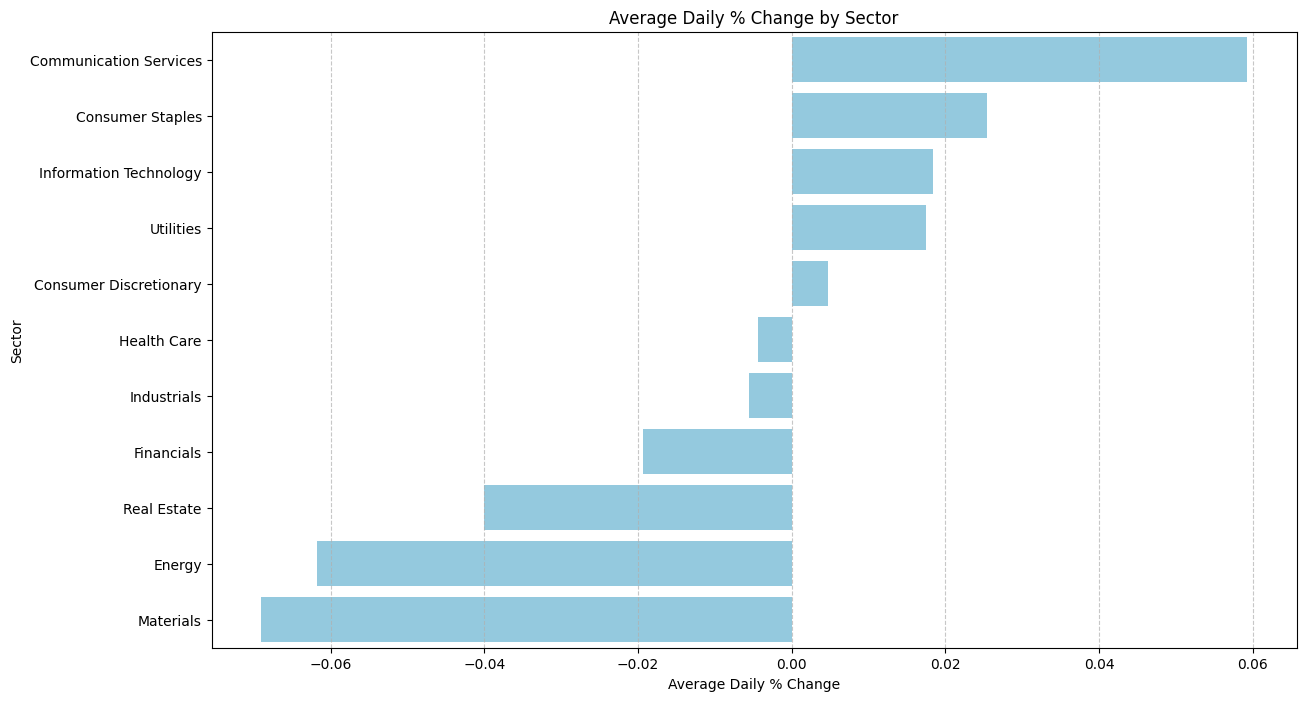

In [36]:
# Create a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (14, 8))
sns.barplot(x = sector_avg_return.values, y = sector_avg_return.index, color = "skyblue")
plt.title("Average Daily % Change by Sector")
plt.xlabel("Average Daily % Change")
plt.ylabel("Sector")
plt.grid(True, axis = 'x', linestyle = '--', alpha = 0.7)
plt.show()

In [37]:
# Calculate the price daily movement
yh_stocksector["Daily Movement"] = yh_stocksector["High"] - yh_stocksector["Low"]

# Group the daily movement by sector
sector_avg_movement = yh_stocksector.groupby("Company Sector")["Daily Movement"].mean().sort_values(ascending = False)

# Display the result
print("Industry sectors by daily price movement")
display(sector_avg_movement)

Industry sectors by daily price movement


Company Sector
Consumer Discretionary    12.413420
Information Technology     7.250573
Health Care                6.429867
Industrials                6.006225
Energy                     5.178196
Financials                 4.553998
Communication Services     4.414435
Materials                  3.403192
Real Estate                3.240349
Consumer Staples           2.395360
Utilities                  2.171725
Name: Daily Movement, dtype: float64

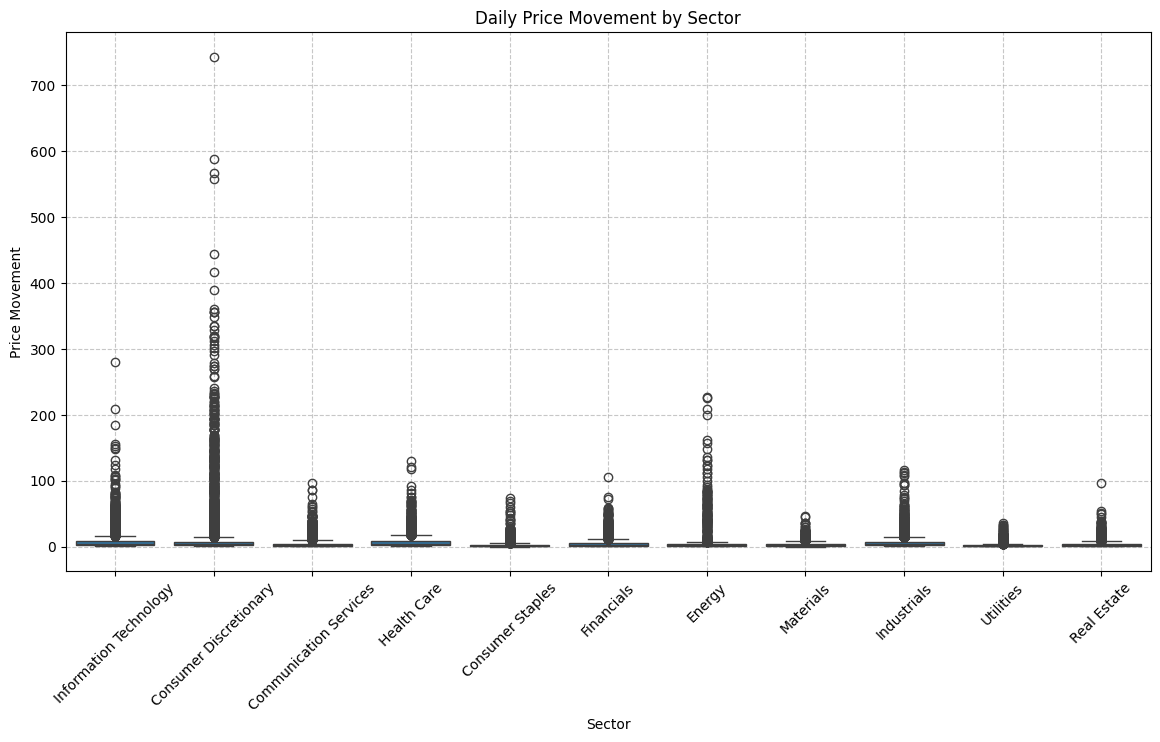

In [38]:
# Create a boxplot of daily movement by sector
plt.figure(figsize = (14,7))
sns.boxplot(x = "Company Sector", y = "Daily Movement", data = yh_stocksector)
plt.xticks(rotation = 45)
plt.title("Daily Price Movement by Sector")
plt.xlabel("Sector")
plt.ylabel("Price Movement")
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.show()

#### Question 3: Which stocks exhibit the highest/lowest volatility based on daily price range?

In [39]:
# Calculate the daily volatility
yh_stocksector["Daily Volatility"] = yh_stocksector["High"] - yh_stocksector["Low"]

# Find the average daily volatility per stock
avg_volatility = yh_stocksector.groupby("Ticker")["Daily Volatility"].mean().sort_values(ascending = False)

In [40]:
# Display top 10 most volatile stocks
top_volatile = avg_volatility.head(10)

print("Top 10 Most Volatile Stocks:")
display(top_volatile)

Top 10 Most Volatile Stocks:


Ticker
NVR     201.759940
BKNG    123.455954
AZO      68.729101
TPL      65.025952
FICO     59.466911
MTD      35.975526
TDG      33.943341
MPWR     30.563098
NOW      27.621624
NFLX     27.197153
Name: Daily Volatility, dtype: float64

In [41]:
# Display top 10 least volatile stocks
least_volatile = avg_volatility.tail(10)

print("\nBottom 10 Least Volatile Stocks:")
display(least_volatile)


Bottom 10 Least Volatile Stocks:


Ticker
WBD     0.457480
HST     0.449062
PCG     0.445967
WBA     0.432687
HBAN    0.406643
PARA    0.319962
VTRS    0.317979
K       0.284967
F       0.282125
AMCR    0.205581
Name: Daily Volatility, dtype: float64

#### Question 4: Which stocks have unusual trading volume activity today relative to their normal average volume?

In [42]:
# Create 30 days average volume per stock
avg30d_volume = (yh_stocksector.groupby("Ticker")["Volume"].mean().reset_index().rename(columns={"Volume": "30 Days Avg Volume"}))

display(avg30d_volume)

,Ticker,30 Days Avg Volume
0,A,1.988643e+06
1,AAPL,5.454401e+07
2,ABBV,7.078379e+06
3,ABNB,5.276380e+06
4,ABT,6.393492e+06
...,...,...
496,XYL,1.617123e+06
497,YUM,2.112649e+06
498,ZBH,1.853403e+06
499,ZBRA,5.397268e+05


In [52]:
# Merge with the latest stock price
sp500_latestprice = pd.merge(
    sp500_latestprice,
    avg30d_volume,
    on = "Ticker",
    how = "left"
)

# Calculate the volume spike ratio
sp500_latestprice["Volume Spike Ratio"] = sp500_latestprice["Volume"] / sp500_latestprice["30 Days Avg Volume"]

display(sp500_latestprice.head())

,Ticker,Company Name,Company Sector,Date,Stock Price,Price % Change (Numeric),Open,High,Low,Close,Volume,Volume Spike Ratio,30 Days Avg Volume
0,CINF,Cincinnati Financial Corporation,Financials,2025-04-25,133.69,-1.23,134.399994,135.039993,132.139999,133.690002,686800.0,0.938939,7.314642e+05
1,LKQ,LKQ Corporation,Consumer Discretionary,2025-04-25,37.41,0.40,37.599998,37.619999,36.209999,37.410000,4324400.0,1.725235,2.506557e+06
2,BEN,"Franklin Resources, Inc.",Financials,2025-04-25,18.72,-0.16,18.650000,18.820000,18.520000,18.719999,3536200.0,0.805045,4.392551e+06
3,DOC,"Healthpeak Properties, Inc.",Real Estate,2025-04-25,17.83,-5.21,18.809999,18.830000,17.590000,17.830000,11084800.0,2.147400,5.161964e+06
4,REG,Regency Centers Corporation,Real Estate,2025-04-25,71.42,-0.04,71.720001,71.879997,70.510002,71.419998,1053600.0,0.932936,1.129337e+06


In [54]:
# Save the new dataframe into csv
sp500_latestprice.to_csv("sp500_latestprice.csv", index = False)

In [56]:
# Using hypothesis test will calculate to see the difference between high volume spike and normal groups
# Sort stocks by volume spike ratio
sp500_latestprice_sorted = sp500_latestprice.sort_values("Volume Spike Ratio", ascending = False)

# Define the top 10% as "High Volume Spike" group
cutoff_index = int(len(sp500_latestprice_sorted) * 0.10)

# Split into two groups
high_spike_group = sp500_latestprice_sorted.iloc[:cutoff_index]
normal_volume_group = sp500_latestprice_sorted.iloc[cutoff_index:]

# Get the price % change for each group
high_spike_change = high_spike_group["Price % Change (Numeric)"]
normal_volume_change = normal_volume_group["Price % Change (Numeric)"]

In [57]:
from scipy.stats import ttest_ind
# Run independent two-sample t-test
t_stat, p_val = ttest_ind(high_spike_change, normal_volume_change, equal_var = False)

print("T-statistic:", t_stat)
print("P-value:", p_val)

# Interpret the result
if p_val < 0.05:
    print("There is statistically significant difference in price change between high-volume and normal-volume stocks!")
else:
    print("There is no statistically significant difference found between the two groups.")

T-statistic: -0.594179875408765
P-value: 0.5550830649410157
There is no statistically significant difference found between the two groups.


In [58]:
# Display a table clearly shows which stocks had unusual volume change today
# Sort by volume spike ratio
top_volume_spikes = sp500_latestprice.sort_values("Volume Spike Ratio", ascending = False).head(10)

# Display the columns
print("Top 10 stocks with unusual volume change")
display(top_volume_spikes[["Ticker", "Volume", "30 Days Avg Volume", "Volume Spike Ratio"]])

Top 10 stocks with unusual volume change


,Ticker,Volume,30 Days Avg Volume,Volume Spike Ratio
302,AON,5317700.0,1.200211e+06,4.430636
18,TMUS,13555100.0,4.025410e+06,3.367384
75,FI,7894300.0,3.155171e+06,2.502020
442,ODFL,4092800.0,1.705740e+06,2.399428
17,WTW,1557400.0,6.880187e+05,2.263601
415,CMG,26657600.0,1.191273e+07,2.237741
202,HAS,3857100.0,1.795716e+06,2.147945
3,DOC,11084800.0,5.161964e+06,2.147400
315,OTIS,4901100.0,2.297143e+06,2.133563
165,ERIE,326400.0,1.542659e+05,2.115828


C:\Users\Nitan\AppData\Local\Temp\ipykernel_27232\1240336248.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


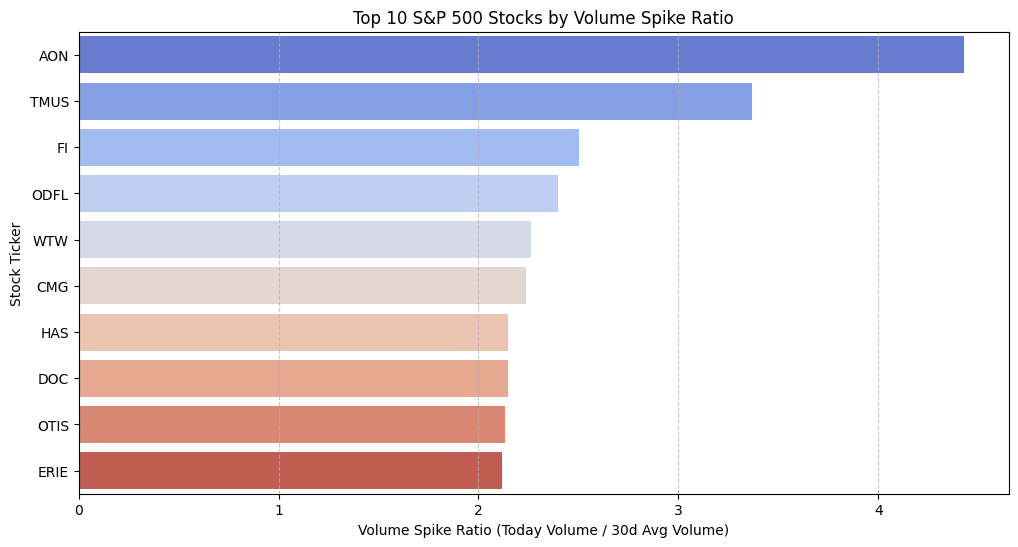

In [59]:
# Show a bar plot of top 10 volume spike ratios
plt.figure(figsize = (12,6))
sns.barplot(
    x = top_volume_spikes["Volume Spike Ratio"], 
    y = top_volume_spikes["Ticker"], 
    palette = "coolwarm"
)
plt.title("Top 10 S&P 500 Stocks by Volume Spike Ratio")
plt.xlabel("Volume Spike Ratio (Today Volume / 30d Avg Volume)")
plt.ylabel("Stock Ticker")
plt.grid(True, axis = 'x', linestyle = '--', alpha = 0.7)
plt.show()